# Transfer Learningh and Fine Tuning 

Initially CV tasks require to train the model from scratch, which means the model model inference is random at the beginning of training. 

Usually to achieve competitive accuracy it requires huge amount of training data and lot of computational resources.

But having the model trained once (**pretrained model**), it is possible to reuse existing knowledge of pretrained model (use its parameters) to train new one.

This approach is called **transfer learning**. The benefits are reduced time of training and less amount of necessary images for training.


Top layers of pretrained model are **cut off** and all remaining layers are kept freeze during training,  whereas only **new layers added** on the top are trainable. 

New layers satisfy custom classes labeling.


In [23]:
!wget https://www.dropbox.com/s/zs1nj2tx1q9f0tj/transfer_learning1.png?dl=0 -O transfer_learning.jpeg

--2021-10-11 12:58:03--  https://www.dropbox.com/s/zs1nj2tx1q9f0tj/transfer_learning1.png?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/zs1nj2tx1q9f0tj/transfer_learning1.png [following]
--2021-10-11 12:58:03--  https://www.dropbox.com/s/raw/zs1nj2tx1q9f0tj/transfer_learning1.png
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc44486ccfc0332c00099c0f4bd7.dl.dropboxusercontent.com/cd/0/inline/BX2tePe0XRJqDV1nFud-lPltJHTg4w2yVl6RH1zWoH8QX7qHkhhFJZ507wf4jk90ljANpZ6XrleE-_jprgbZZRYHQbQuHkDC0ToRcy-qOji5RPn0hsDILAB1DNbdRmuGG5d_d6W841fkcngQhCKrKEXi/file# [following]
--2021-10-11 12:58:04--  https://uc44486ccfc0332c00099c0f4bd7.dl.dropboxusercontent.com/cd/0/inline/BX2tePe0XRJqDV1nFud-lPltJHTg4w2yVl6RH1zWoH8QX7qHkhhF

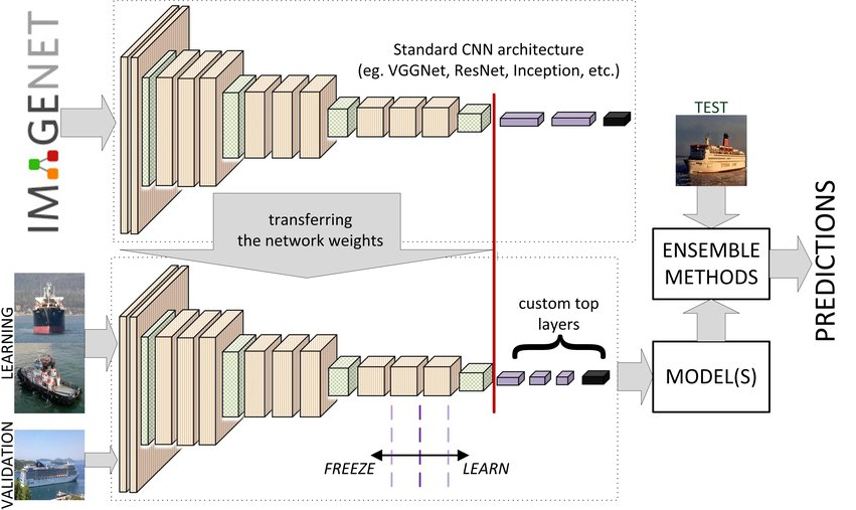

In [25]:
from IPython.display import Image
Image('transfer_learning.jpeg', width = 800)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.applications import vgg16

from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras import Sequential, optimizers

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

import random
import os

%matplotlib inline

In [4]:
# settings for reproducibility
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# is_use_gpu = True
# if is_use_gpu:
#     gpu_devices = tf.config.list_physical_devices('GPU')
#     tf.config.experimental.set_visible_devices(gpu_devices[0], 'GPU')
#     tf.config.experimental.set_memory_growth(gpu_devices[0], True)
#     os.environ['TF_USE_CUDNN'] = '1'
# else:
#     os.environ["CUDA_VISIBLE_DEVICES"] ="-1"

Define locations of the train and validation datasets:

In [5]:
# each folder contains three subfolders in accordance with the number of classes
train_dir = '/content/drive/MyDrive/Data_Science_Camp_2021/lesson_26_CV/clean-dataset/train'
validation_dir = '/content/drive/MyDrive/Data_Science_Camp_2021/lesson_26_CV/clean-dataset/validation'

image_size = 224

## Transfer Learning 

Freezing all layers layers 

<h3>1. Freezing all layers</h3>

Create the model setting ``include_top`` parameter to ``False`` in order to exclude the fully-connected layers at the top of the network.

In [5]:
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout

# Init the VGG model 
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Freeze all the layers
for layer in vgg_conv.layers[:]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

# Create the model

model = Sequential()

# Add the vgg convolutional base model
model.add(vgg_conv)

# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

58900480/58889256 [==============================] - 1s 0us/step
<keras.engine.input_layer.InputLayer object at 0x7f43e67681d0> False
<keras.layers.convolutional.Conv2D object at 0x7f4434d9cfd0> False
<keras.layers.convolutional.Conv2D object at 0x7f43e5e8e510> False
<keras.layers.pooling.MaxPooling2D object at 0x7f43e5e5f0d0> False
<keras.layers.convolutional.Conv2D object at 0x7f43e04ca610> False
<keras.layers.convolutional.Conv2D object at 0x7f43e04ce750> False
<keras.layers.pooling.MaxPooling2D object at 0x7f43e5e26350> False
<keras.layers.convolutional.Conv2D object at 0x7f43e04d2c90> False
<keras.layers.convolutional.Conv2D object at 0x7f43e04d9810> False
<keras.layers.convolutional.Conv2D object at 0x7f43e04d4150> False
<keras.layers.pooling.MaxPooling2D object at 0x7f43e04e81d0> False
<keras.layers.convolutional.Conv2D object at 0x7f43e04eba50> False
<keras.layers.convolutional.Conv2D object at 0x7f43e04f0d10> False
<keras.layers.convolutional.Conv2D object at 0x7f43e04e1b50> F

<h3>2. Prepare the training and validation data</h3>

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the normalized images
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Change the batchsize according to your system RAM
train_batchsize = 100
val_batchsize = 10

# Data generator for training data
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')

# Data generator for validation data
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 409 images belonging to 2 classes.
Found 95 images belonging to 2 classes.


<h3>3. Visualizing the datasets</h3>

In [30]:
# Utility function for quick class name access
def get_class_name(generator, image_id):
    # Get the image class and map its index with the names of the classes
    image_label_id = np.argmax(generator[image_id][1][0])
    classes_list = list(generator.class_indices.keys())
    return classes_list[image_label_id]

Text(0.5, 1.0, 'Validation class name: cow')

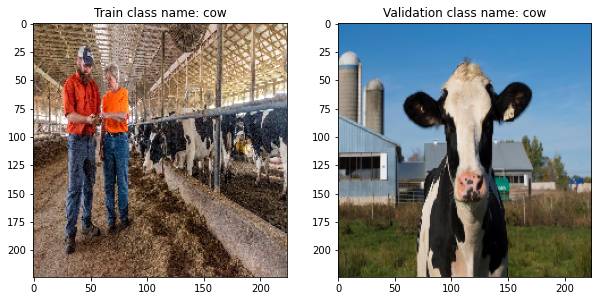

In [8]:
import matplotlib.pyplot as plt
import numpy as np 
# %matplotlib inline

# Choose the image index for the visualization
image_id = 3

# Get the train image shape 
# print("The shape of train images: {}".format(train_generator[image_id][0][0].shape))

# Get the validation image shape 
# print("The shape of validation images: {}".format(validation_generator[image_id][0][0].shape))

# Visualize the train image example
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.imshow(train_generator[image_id][0][0])

# Show the train image class
plt.title("Train class name: {}".format(get_class_name(train_generator, image_id)))

# Visualize the validation image example
plt.subplot(122)
plt.imshow(validation_generator[image_id][0][0])

# show image class
plt.title("Validation class name: {}".format(get_class_name(validation_generator, image_id)))

<h3>4. Train the model</h3>

In [9]:
# Utility function for plotting of the model results
def visualize_results(history):
    # Plot the accuracy and loss curves
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 40,407,874
Trainable params: 25,693,186
Non-trainable params: 14,714,688
_________________________________________________________________


In [11]:
int(np.ceil(train_generator.samples /train_generator.batch_size))
# train_batchsize = 100
# val_batchsize = 10



5

In [12]:
# Configure the model for training
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Train the model
history = model.fit(
      train_generator,
      steps_per_epoch=int(np.ceil(train_generator.samples /train_generator.batch_size)),
      epochs=20,
      validation_data=validation_generator,
      validation_steps=int(np.ceil(validation_generator.samples/validation_generator.batch_size)),
      verbose=1)

# Save the model
model.save('all_freezed.h5')


# ignore the error  - it is fixed but I kust did not want to re-run traing 

Epoch 1/20
1/5 [=====>........................] - ETA: 4:29 - loss: 0.9478 - accuracy: 0.4400

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


5/5 [==============================] - 125s 14s/step - loss: 39.0547 - accuracy: 0.4743 - val_loss: 5.6815 - val_accuracy: 0.5053
Epoch 2/20
5/5 [==============================] - 15s 3s/step - loss: 6.4344 - accuracy: 0.5379 - val_loss: 0.7781 - val_accuracy: 0.7368
Epoch 3/20
5/5 [==============================] - 15s 3s/step - loss: 3.2891 - accuracy: 0.6210 - val_loss: 2.8657 - val_accuracy: 0.5263
Epoch 4/20
5/5 [==============================] - 15s 3s/step - loss: 2.8965 - accuracy: 0.5990 - val_loss: 1.4522 - val_accuracy: 0.6316
Epoch 5/20
5/5 [==============================] - 15s 4s/step - loss: 1.1041 - accuracy: 0.7653 - val_loss: 0.6624 - val_accuracy: 0.7474
Epoch 6/20
5/5 [==============================] - 14s 3s/step - loss: 1.6845 - accuracy: 0.6895 - val_loss: 0.5497 - val_accuracy: 0.7684
Epoch 7/20
5/5 [==============================] - 14s 3s/step - loss: 0.3630 - accuracy: 0.8900 - val_loss: 0.3375 - val_accuracy: 0.8947
Epoch 8/20
5/5 [==========================

KeyError: ignored

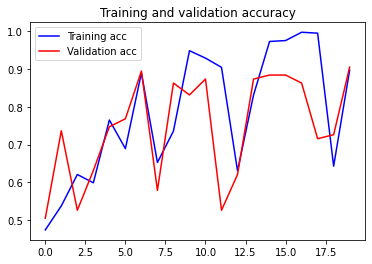

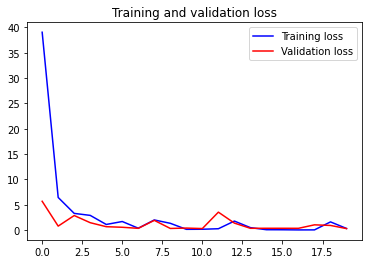

In [14]:
# Run the function to illustrate accuracy and loss
visualize_results(history)

In [18]:
score = model.evaluate(validation_generator)
# 'categorical_crossentropy', 'accuracy'
score

10/10 [==============================] - 3s 277ms/step - loss: 0.2866 - accuracy: 0.9053


[0.28660497069358826, 0.9052631855010986]

<h3>5. Show the errors</h3>

Let's define a couple of utility functions to avoid a code duplication in further experiments.

In [12]:
# Utility function for obtaining of the errors 
def obtain_errors(val_generator, predictions):
    # Get the filenames from the generator
    fnames = validation_generator.filenames

    # Get the ground truth from generator
    ground_truth = validation_generator.classes

    # Get the dictionary of classes
    label2index = validation_generator.class_indices

    # Obtain the list of the classes
    idx2label = list(label2index.keys())
    print("The list of classes: ", idx2label)

    # Get the class index
    predicted_classes = np.argmax(predictions, axis=1)

    errors = np.where(predicted_classes != ground_truth)[0]
    print("Number of errors = {}/{}".format(len(errors),validation_generator.samples))
    
    return idx2label, errors, fnames

In [14]:
# Utility function for visualization of the errors
def show_errors(idx2label, errors, predictions, fnames):
    # Show the errors
    for i in range(len(errors)):
        pred_class = np.argmax(predictions[errors[i]])
        pred_label = idx2label[pred_class]

        title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
            fnames[errors[i]].split('/')[0],
            pred_label,
            predictions[errors[i]][pred_class])

        original = load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))
        plt.figure(figsize=[7,7])
        plt.axis('off')
        plt.title(title)
        plt.imshow(original)
        plt.show()

9/9 [==============================] - 3s 252ms/step
The list of classes:  ['cow', 'horse']
Number of errors = 9/95


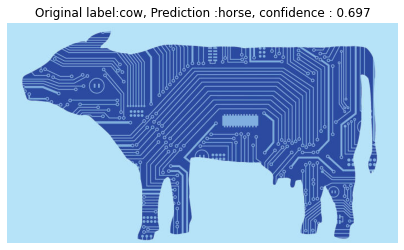

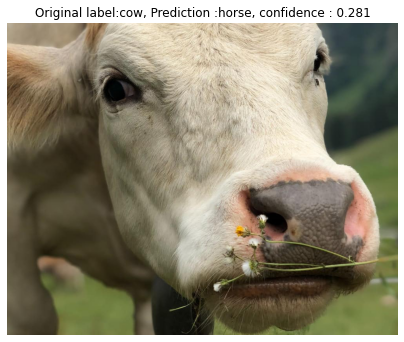

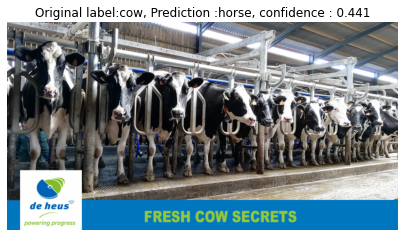

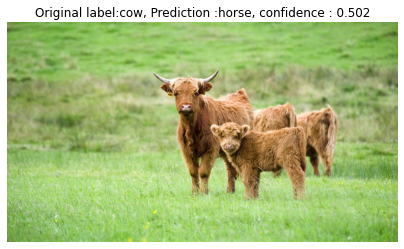

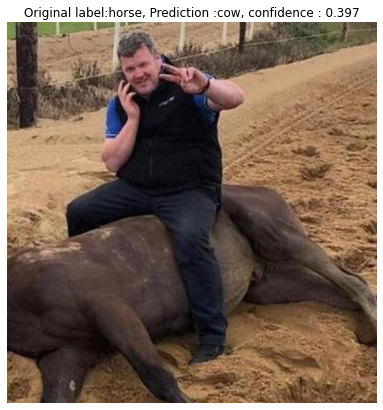

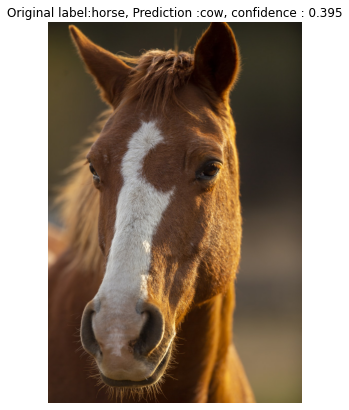

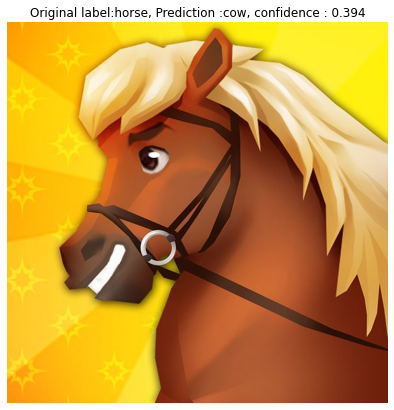

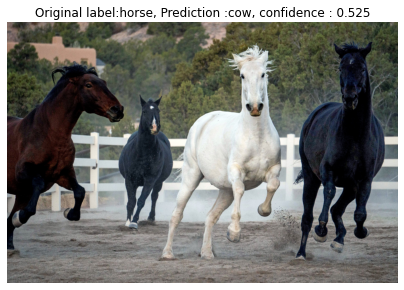

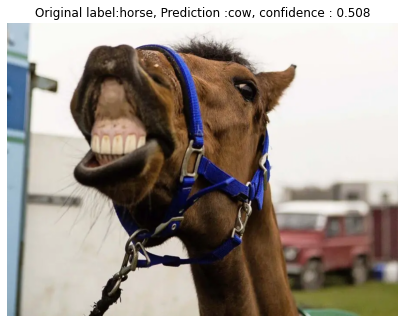

In [21]:
# Get the predictions from the model using the generator
predictions = model.predict(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1)

# Run the function to get the list of classes and errors
idx2label, errors, fnames = obtain_errors(validation_generator, predictions)

# Run the function to illustrate the error cases
show_errors(idx2label, errors, predictions, fnames)

## Experiment 2: Fine Tuning (Train Last 4 layers) without data augmentation

<h3>1. Setup the freeze layers</h3>

Create the model setting include_top parameter to False in order to exclude the fully-connected layers at the top of the network.

In [6]:
#Load the VGG model
vgg_conv = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Freeze all the layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

# Create the model
model = Sequential()

# Add the vgg convolutional base model
model.add(vgg_conv)

# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

58900480/58889256 [==============================] - 1s 0us/step
<keras.engine.input_layer.InputLayer object at 0x7f98969d1e90> False
<keras.layers.convolutional.Conv2D object at 0x7f98411d2a10> False
<keras.layers.convolutional.Conv2D object at 0x7f98411d2b50> False
<keras.layers.pooling.MaxPooling2D object at 0x7f9830448610> False
<keras.layers.convolutional.Conv2D object at 0x7f98410ecd10> False
<keras.layers.convolutional.Conv2D object at 0x7f983044e3d0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f9830456690> False
<keras.layers.convolutional.Conv2D object at 0x7f98304526d0> False
<keras.layers.convolutional.Conv2D object at 0x7f9830459e90> False
<keras.layers.convolutional.Conv2D object at 0x7f9830462ed0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f9830469f50> False
<keras.layers.convolutional.Conv2D object at 0x7f9830462550> False
<keras.layers.convolutional.Conv2D object at 0x7f9830471590> False
<keras.layers.convolutional.Conv2D object at 0x7f9830478790> F

<h3>2. Prepare the training and validation data</h3>

In [7]:
# No data augmentation 
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Change the batchsize according to your system RAM
train_batchsize = 100
val_batchsize = 10

# Data generator for training data
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')

# Data generator for validation data
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 409 images belonging to 2 classes.
Found 95 images belonging to 2 classes.


<h3>3. Train the last 4 layers without data augmentation</h3>

In [8]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

# Train the model
history = model.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)

# Save the model
model.save('last4_layers.h5')

# Run the function to illustrate accuracy and loss
visualize_results(history)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
1/4 [======>.......................] - ETA: 6:16 - loss: 0.9478 - accuracy: 0.4400

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


4/4 [==============================] - 325s 66s/step - loss: 3.2181 - accuracy: 0.5012 - val_loss: 0.7481 - val_accuracy: 0.5053
Epoch 2/20
4/4 [==============================] - 17s 4s/step - loss: 1.0801 - accuracy: 0.4866 - val_loss: 0.6679 - val_accuracy: 0.6105
Epoch 3/20
4/4 [==============================] - 16s 4s/step - loss: 0.6917 - accuracy: 0.5795 - val_loss: 0.6027 - val_accuracy: 0.6421
Epoch 4/20
4/4 [==============================] - 16s 4s/step - loss: 0.5561 - accuracy: 0.7262 - val_loss: 0.5650 - val_accuracy: 0.6421
Epoch 5/20
4/4 [==============================] - 16s 5s/step - loss: 0.6808 - accuracy: 0.6675 - val_loss: 0.9677 - val_accuracy: 0.4947
Epoch 6/20
4/4 [==============================] - 16s 4s/step - loss: 0.6182 - accuracy: 0.6895 - val_loss: 0.4418 - val_accuracy: 0.8105
Epoch 7/20
4/4 [==============================] - 16s 4s/step - loss: 0.3421 - accuracy: 0.8411 - val_loss: 0.4565 - val_accuracy: 0.8000
Epoch 8/20
4/4 [===========================

NameError: ignored

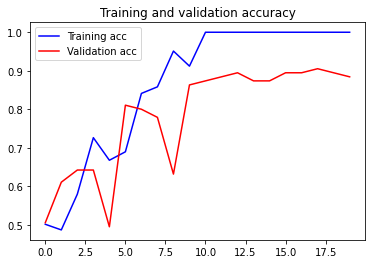

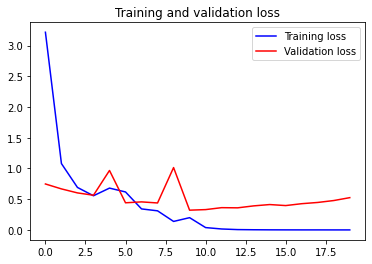

In [10]:
visualize_results(history)

<h3>4. Show the errors</h3>

9/9 [==============================] - 3s 259ms/step
The list of classes:  ['cow', 'horse']
Number of errors = 11/95


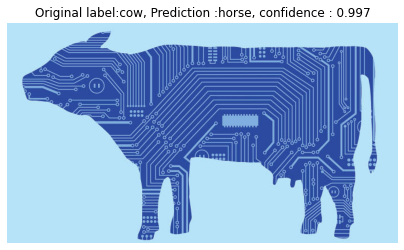

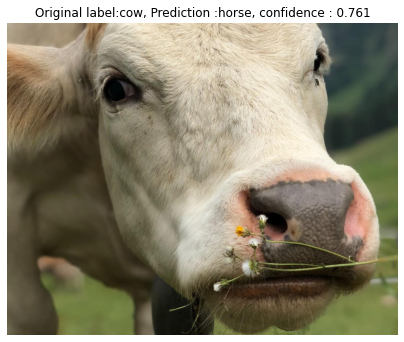

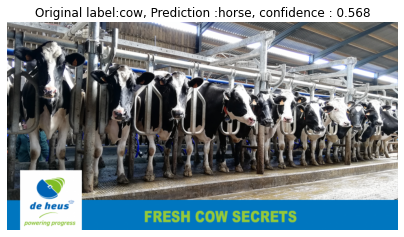

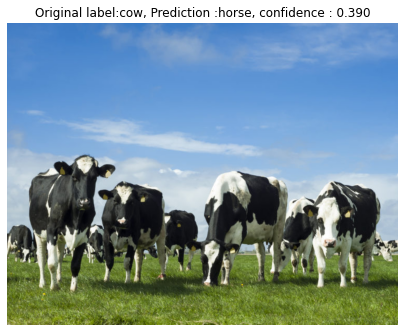

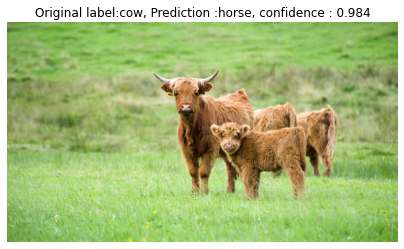

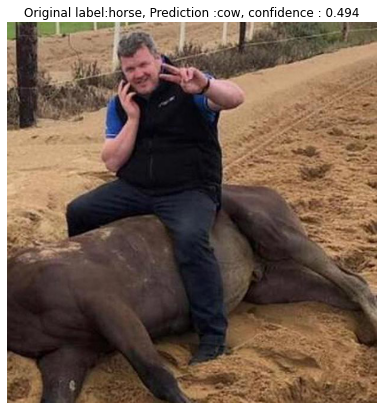

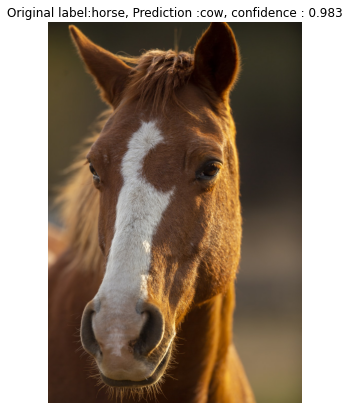

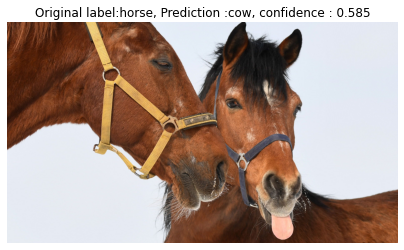

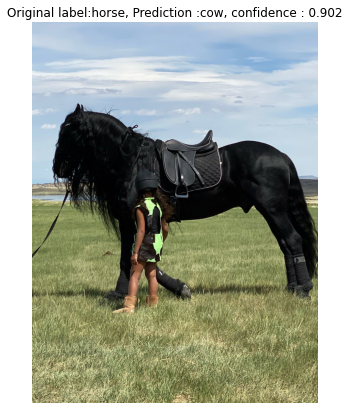

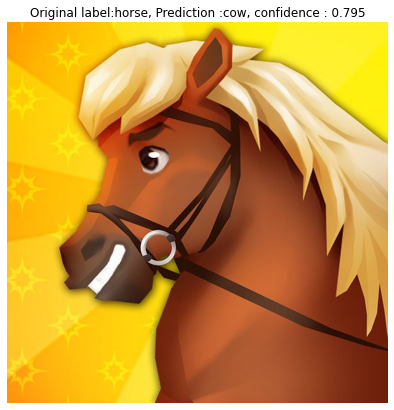

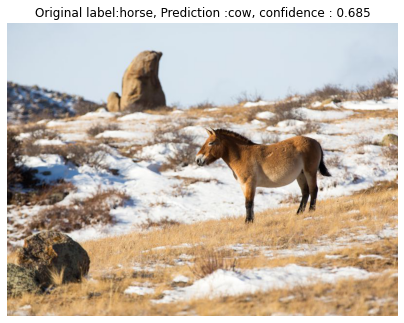

In [15]:
# Get the predictions from the model using the generator
predictions = model.predict(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1)

# Run the function to get the list of classes and errors
idx2label, errors, fnames = obtain_errors(validation_generator, predictions)

# Run the function to illustrate the error cases
show_errors(idx2label, errors, predictions, fnames)

## Fine Tuning with data augmentation 

<h3>1. Freeze bottom layers</h3>

Create the model setting include_top parameter to False in order to exclude the fully-connected layers at the top of the network.

In [27]:
#Load the VGG model
vgg_conv = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Freeze all the layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

# Create the model
model = Sequential()

# Add the vgg convolutional base model
model.add(vgg_conv)

# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
# model.add(Dense(3, activation='softmax'))
model.add(Dense(2, activation='sigmoid'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

<keras.engine.input_layer.InputLayer object at 0x7f97519b3d90> False
<keras.layers.convolutional.Conv2D object at 0x7f97519b3ed0> False
<keras.layers.convolutional.Conv2D object at 0x7f97519a7790> False
<keras.layers.pooling.MaxPooling2D object at 0x7f97519a9590> False
<keras.layers.convolutional.Conv2D object at 0x7f97519ece50> False
<keras.layers.convolutional.Conv2D object at 0x7f97519aa150> False
<keras.layers.pooling.MaxPooling2D object at 0x7f97519c2090> False
<keras.layers.convolutional.Conv2D object at 0x7f97519bcc10> False
<keras.layers.convolutional.Conv2D object at 0x7f97519c5650> False
<keras.layers.convolutional.Conv2D object at 0x7f97519508d0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f9751955e50> False
<keras.layers.convolutional.Conv2D object at 0x7f97519c5410> False
<keras.layers.convolutional.Conv2D object at 0x7f975195f050> False
<keras.layers.convolutional.Conv2D object at 0x7f9751968190> False
<keras.layers.pooling.MaxPooling2D object at 0x7f975195f410>

<h3>2. Prepare the training and validation data</h3>

In [28]:
# generate batches of train transformed images and labels
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

# Change the batchsize according to your system RAM
train_batchsize = 50
val_batchsize = 10

# Data generator for training data
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')

# Data generator for validation data
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 409 images belonging to 2 classes.
Found 95 images belonging to 2 classes.


<h3>3. Visualizing the datasets</h3>

The shape of train images: (224, 224, 3)


Text(0.5, 1.0, 'Train class name: cow')

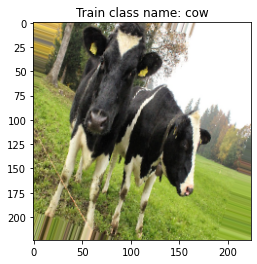

In [31]:
# Choose the image index for the visualization
image_id = 5

# Get the train image shape 
print("The shape of train images: {}".format(train_generator[image_id][0][0].shape))

# Visualize the train image example
plt.imshow(train_generator[image_id][0][0])

# Show the train image class
plt.title("Train class name: {}".format(get_class_name(train_generator, image_id)))

<h3>4. Train the model. Here we will be using the imageDataGenerator for data augmentation</h3>

Epoch 1/40
8/8 [============================>.] - ETA: 0s - loss: 0.8894 - accuracy: 0.5877

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


8/8 [==============================] - 22s 2s/step - loss: 0.8602 - accuracy: 0.5868 - val_loss: 0.5791 - val_accuracy: 0.8000
Epoch 2/40
8/8 [==============================] - 20s 2s/step - loss: 0.7479 - accuracy: 0.6161 - val_loss: 0.4083 - val_accuracy: 0.8737
Epoch 3/40
8/8 [==============================] - 20s 2s/step - loss: 0.5265 - accuracy: 0.7579 - val_loss: 0.4214 - val_accuracy: 0.8316
Epoch 4/40
8/8 [==============================] - 20s 2s/step - loss: 0.3473 - accuracy: 0.8509 - val_loss: 0.3754 - val_accuracy: 0.8105
Epoch 5/40
8/8 [==============================] - 20s 2s/step - loss: 0.3688 - accuracy: 0.8484 - val_loss: 0.6907 - val_accuracy: 0.7263
Epoch 6/40
8/8 [==============================] - 20s 2s/step - loss: 0.3588 - accuracy: 0.8386 - val_loss: 0.4665 - val_accuracy: 0.8000
Epoch 7/40
8/8 [==============================] - 20s 3s/step - loss: 0.2983 - accuracy: 0.8680 - val_loss: 0.2653 - val_accuracy: 0.8737
Epoch 8/40
8/8 [=============================

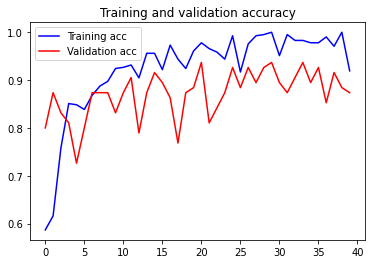

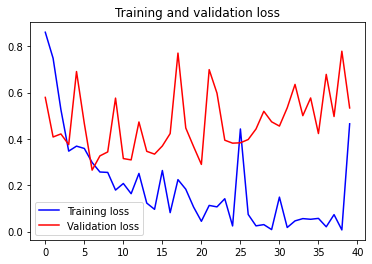

In [33]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

# Train the model
history = model.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size,
      epochs=40,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)

# Save the model
model.save('da_last4_layers.h5')

# Run the function to illustrate accuracy and loss
visualize_results(history)

<h3>5. Show the errors</h3>

9/9 [==============================] - 3s 259ms/step
The list of classes:  ['cow', 'horse']
Number of errors = 12/95


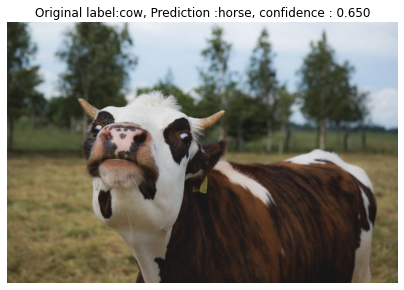

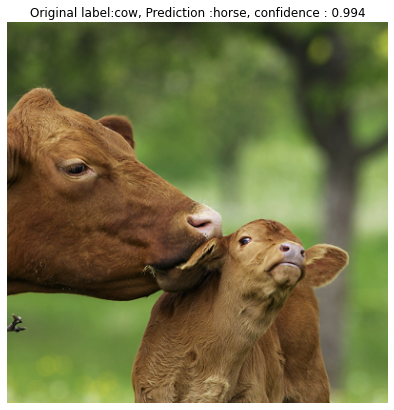

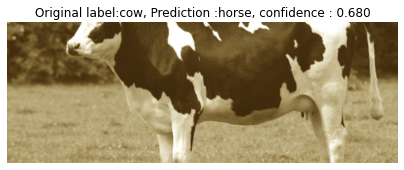

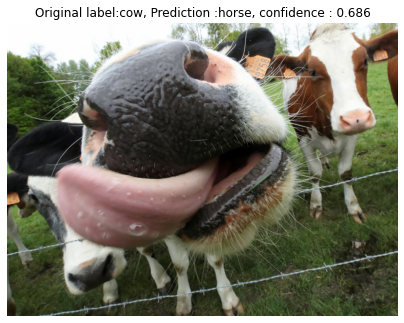

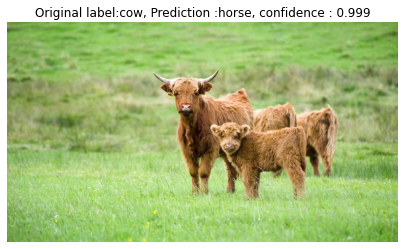

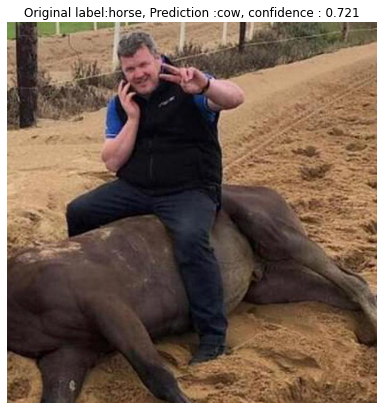

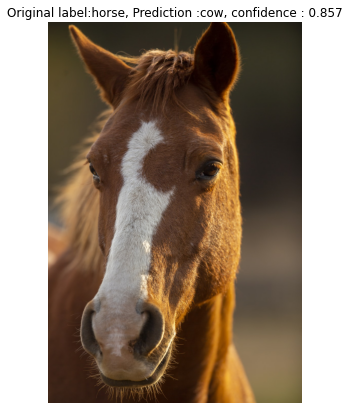

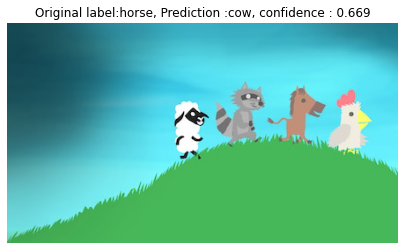

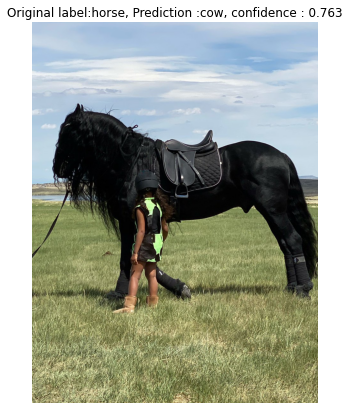

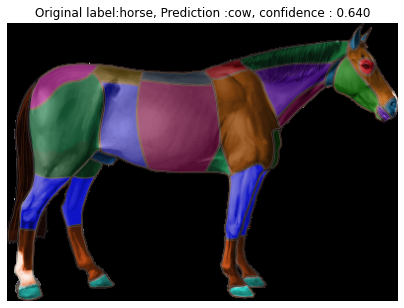

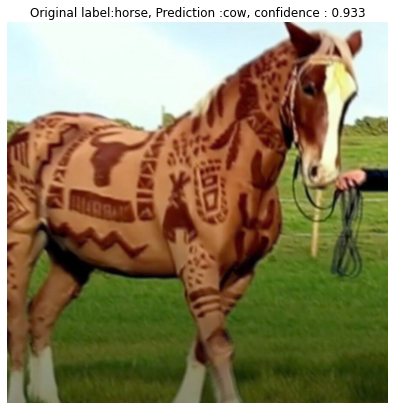

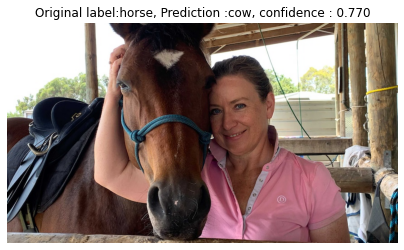

In [34]:
# Get the predictions from the model using the generator
predictions = model.predict(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1)

# Run the function to get the list of classes and errors
idx2label, errors, fnames = obtain_errors(validation_generator, predictions)

# Run the function to illustrate the error cases
show_errors(idx2label, errors, predictions, fnames)